Import des modules nécéssaires au projet:

In [65]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import math
import time

Initialisation des valeurs basiques:

In [66]:
temperatures_montreal = np.load("Temperatures-Montreal.npy")
eta = 0.99
max_pump_power = 1 # kW
Cp = 0.4 # °C/1kWh
T_min = 19 # °C
T_max = 21 # °C
inconfort_penality_supp = 1
inconfort_penality_inf = 3
ref_week_start_idx = 13050 # mi-avril 
arbitrary_week_start_idx = 18300 # début juin (arbitrary)
computing_intervals_amount = 7*24*4 
task_3_step = 2 # arbitrary
mid_temperature = (T_max + T_min)//2  
task_2_budget_coefficient = 0.9 # arbitrary

# Initialisation du tarif bi-horaire pour les couts d'éléctricité
electricity_cost = [0.18 if (i % (24*4)) /4 >= 22 or (i % (24*4))/4 < 7 else 0.26 for i in range(len(temperatures_montreal))] 

# Fonction qui renvoie la COP de chauffe
def COP_warming(T_ext):
    return 3 + 10 * abs(np.tanh(T_ext/100)) * np.tanh(T_ext/100)

# Fonction qui renvoie la COP de refroidissement
def COP_reverse():
    return 3.2

Fonctions pour les taches 1 et 2:

In [67]:
# Fonction qui renvoie la chaleur perdue sans action de la pompe
def next_temperature(T_old, T_ext):
    return - (1-eta) * (T_old - T_ext) + T_old

# Fonction qui effectue la tache 1 et 2 (pour passer a la tache 2, il faut définir max_cost):
def basic(first_interval_idx, max_cost=math.inf):
    inconfort_mode = max_cost != math.inf                                               # Mode inconfort pour faire la tache 1 ou 2 (False ou True)
    # Séléction des intervalles dans toutes les données
    last_interval_idx = first_interval_idx + computing_intervals_amount                                 
    temperatures_ext = temperatures_montreal[first_interval_idx:last_interval_idx]

    p_warming = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en réchauffement
    p_reverse = cp.Variable(computing_intervals_amount, nonneg=True)                    # Puissance de la pompe à l'intervalle i en reverse
    temperatures_int = cp.Variable(computing_intervals_amount)                          # Températures intérieures
    partial_electricity_cost = electricity_cost[first_interval_idx:last_interval_idx]   # Coût de l'électricité sur la période sélectionnée
    
    cost = cp.sum(partial_electricity_cost @ (p_warming + p_reverse) * 4)               # Somme qui décrit le cout en $ du fonctionnement de la pompe

    # Initialisation des contraintes sur les puissances
    constraints = [p_warming >= 0]                 # Minimum 
    constraints += [p_reverse >= 0]                # Minimum
    constraints += [p_warming <= max_pump_power]   # Maximum
    constraints += [p_reverse <= max_pump_power]   # Maximum

    # Initialisation des contraintes sur les températures
    constraints += [temperatures_int[0] == mid_temperature]                                                # Température de début
    constraints += [temperatures_int[-1] == mid_temperature]                                               # Température de fin

    # Initialisation des contraintes de relations entre les températures i et i+1
    constraints += [temperatures_int[1:] == next_temperature(temperatures_int[:-1], temperatures_ext[:-1]) # Perte de chaleur sans action
    + cp.multiply(COP_warming(temperatures_ext[:-1]), p_warming[:-1]) * 4 * Cp                             # Chauffe en mode normal
    - cp.multiply(COP_reverse(), p_reverse[:-1] * 4 * Cp)                                                  # Refroidissement en mode reverse
    ]

    # Si le mode inconfort est True alors on fait la tache 2 
    if inconfort_mode:
        inconforts_sup = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort au dessus de la température max à l'intervalle i
        inconforts_inf = cp.Variable(computing_intervals_amount, nonneg=True)                              # Inconfort en dessous de la température min à l'intervalle i
        objective = cp.sum(inconforts_sup*inconfort_penality_supp + inconfort_penality_inf*inconforts_inf) # Fonction objectif qui représente l'inconfort et doit etre minimisé
        constraints += [cost <= max_cost]                                                                  # La somme du cout devient une contrainte
        constraints += [temperatures_int - T_min >= -inconforts_inf]                                       # Contrainte pour avoir les valeurs de l'inconfort inf
        constraints += [temperatures_int - T_max <= inconforts_sup]                                        # Contrainte pour avoir les valeurs de l'inconfort inf

    # Sinon on fait la tache 1
    else:
        constraints += [temperatures_int >= T_min]  # Contrainte sur la valeur minimum des températures
        constraints += [temperatures_int <= T_max]  # Contrainte sur la valeur maximum des températures
        objective = cost                            # La somme du cout devient l'objectif
     

    problem = cp.Problem(cp.Minimize(objective), constraints)                                                # Définit le probleme avec ses contraintes et son objectif a minimiser
    start_time = time.time()
    solution = problem.solve(solver=cp.SCIPY, scipy_options={"method": "highs"}, warm_start=inconfort_mode)  # Résoud le probleme avec HiGHS et si on fait la tache 2 utilise le mode warm_start
    end_time = time.time()

    # Renvoie les valeurs 
    if cost.value is None: 
        return []
    return [temperatures_int.value, p_warming.value, p_reverse.value, cost.value, problem.value, end_time - start_time]

Fonction pour la tache 3:

In [68]:
# Fonction qui effectue la tache 3
def task3(first_interval_idx, max_cost):
    last_interval_idx = first_interval_idx + computing_intervals_amount
    outputs = []
    max_allocated_budget = np.linspace(0, max_cost, num=100//task_3_step+1) 
    for i in range(len(max_allocated_budget)):
        output = basic(first_interval_idx, max_allocated_budget[i]) # Effectue la tache 2 en changeant le budget par la boucle for
        outputs.append(output)
    return outputs

Fonction qui plot la tache 1:

In [69]:
# Fonction qui plot la tache 1
def plot_1(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx): 
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des températures
        axs[0][i].scatter(x, period[0], s=5)
        axs[0][i].set_title("Période {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        # Plot des puissances
        axs[1][i].scatter(x, period[1], label="Fonctionnement normal", s=5)
        axs[1][i].scatter(x, period[2], label="Fonctionnement reverse", s=5)
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()
        print("1. Coût période {i} : {cost}".format(i=i+1, cost=period[3]))
        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

    fig.canvas.manager.set_window_title("Tâche 1 - Minimisation du coût avec T_min <= T <= T_max")
    plt.show()

Fonction qui plot la tache 2:

In [70]:
# Fonction qui plot la tache 2
def plot_2(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 6))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i] 
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des températures
        axs[0][i].scatter(x, period[0], s=5)
        axs[0][i].set_title("Période  {i} - Évolution des températures".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        x = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)

        # Plot des puissances
        axs[1][i].scatter(x, period[1], label="Fonctionnement normal", s=5)
        axs[1][i].scatter(x, period[2], label="Fonctionnement reverse", s=5)
        axs[1][i].set_title("Période {i} - Utilisation de la pompe à chaleur".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Puissance (kW)")
        axs[1][i].legend()

        plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1) 

        print("2. Inconfort minimal de {inconfort} pour un budget de {budget} à la période {p}".format(inconfort=period[4], budget=period[3], p=i+1))

    fig.canvas.manager.set_window_title("Tâche 2 - Minimisation de l'inconfort avec budget restreint d'un facteur {f}".format(f=task_2_budget_coefficient))
    plt.show()

Fonction qui plot la tache 3:

In [71]:
# Fonction qui plot la tache 3
def plot_3(period_1, period_2, period_1_first_interval_idx, period_2_first_interval_idx):
    periods = [period_1, period_2]
    first_interval_idxs = [period_1_first_interval_idx, period_2_first_interval_idx]

    # Crée la figure
    fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 10))

    # Plot les graphes pour les 2 périodes
    for i in range(len(periods)):
        period = periods[i]
        first_interval_idx = first_interval_idxs[i]
        last_interval_idx = first_interval_idx + computing_intervals_amount

        time = np.linspace(first_interval_idx, last_interval_idx, computing_intervals_amount)
        budget = [o for o in range(0,101,2)]
        inconfort = [o[4] if len(o) != 0 else math.inf for o in period]

        # Titres et légendes des plots des températures par 20%
        axs[0][i].set_title("Période {i} - Évolution des températures par 20%".format(i=i+1))
        axs[0][i].set_xlabel("Intervalle de temps")
        axs[0][i].set_ylabel("Température (°C)")

        # Titres et légendes des plots des températures par 10%
        axs[1][i].set_title("Période {i} - Évolution des températures par 10%".format(i=i+1))
        axs[1][i].set_xlabel("Intervalle de temps")
        axs[1][i].set_ylabel("Température (°C)")

        # Titres et légendes du plot des inconforts
        axs[2][i].set_title("Période {i} - Évolution des inconforts".format(i=i+1))
        axs[2][i].set_xlabel("Budget alloué (%)")
        axs[2][i].set_ylabel("Inconfort")

        for o in range(0,len(period),10):
            output = period[o]
            if len(output) == 0:
                continue
            
            # Plot des températures par 20%
            axs[0][i].scatter(time, output[0], label="{percent}%".format(percent=o*task_3_step), s=2)
            axs[0][i].legend(loc='center left', bbox_to_anchor=(1,0.5))
            plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1)

        for o in range(0,len(period),5):
            output = period[o]
            if len(output) == 0:
                continue

            # Plot des températures par 10%
            axs[1][i].scatter(time, output[0], label="{percent}%".format(percent=o*task_3_step), s=2)
            axs[1][i].legend(loc='center left', bbox_to_anchor=(1,0.5))
            plt. gcf(). subplots_adjust( wspace = 0.7, hspace = 1)

        # Plot des inconforts
        axs[2][i].scatter(budget, inconfort, color='red', s=5)

    fig.canvas.manager.set_window_title("Tâche 3 - Minimisation de l'inconfort avec budget restreint à {step}n%".format(step=task_3_step))
    plt.show()

Appel de toutes les fonctions qui calculent et plot les différentes tâches, imprime aussi les temps d'exécution:

Computed output_1_ref in 0.04487919807434082s
Computed output_1_arbitrary in 0.0336146354675293s
Computed output_2_arbitrary in 0.08485579490661621s
Computed output_2_arbitrary in 0.07860827445983887s
Computed output_3_ref in 4.93994140625s
Average time for output_3_ref: 0.09686398506164551s
Computed output_3_arbitrary in 4.5433571338653564s
Average time for output_3_arbitrary: 0.08908787428164015s
1. Coût période 1 : 8.089750742486272
1. Coût période 2 : 2.8968604529448334


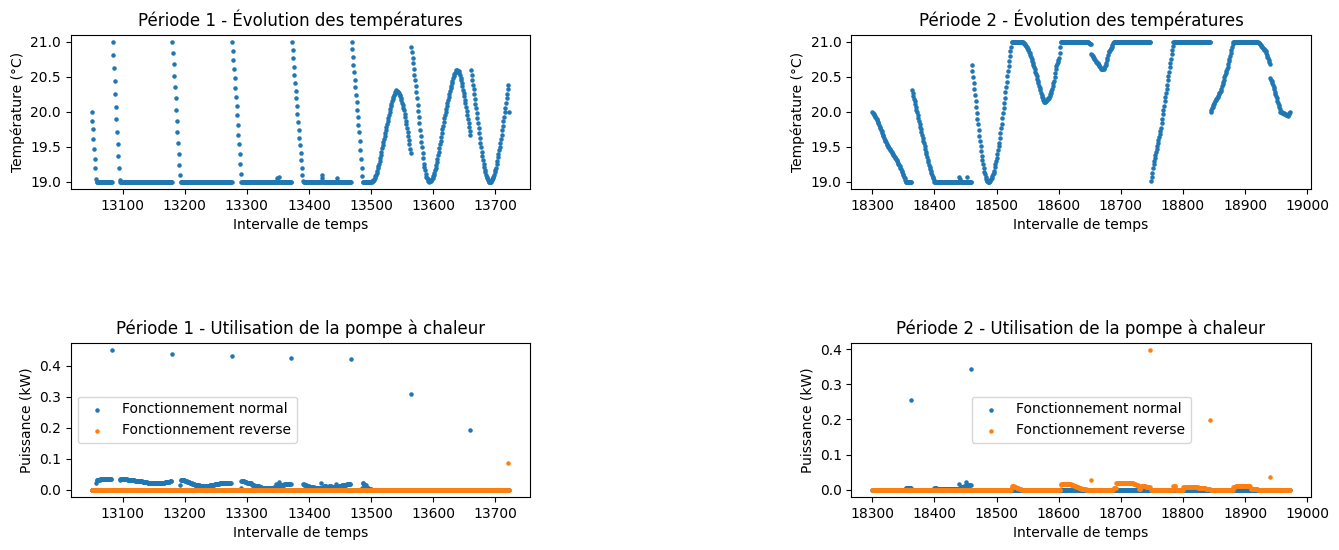

2. Inconfort minimal de 223.03586295473326 pour un budget de 7.280775668237645 à la période 1
2. Inconfort minimal de 27.52474628122266 pour un budget de 2.607174407650351 à la période 2


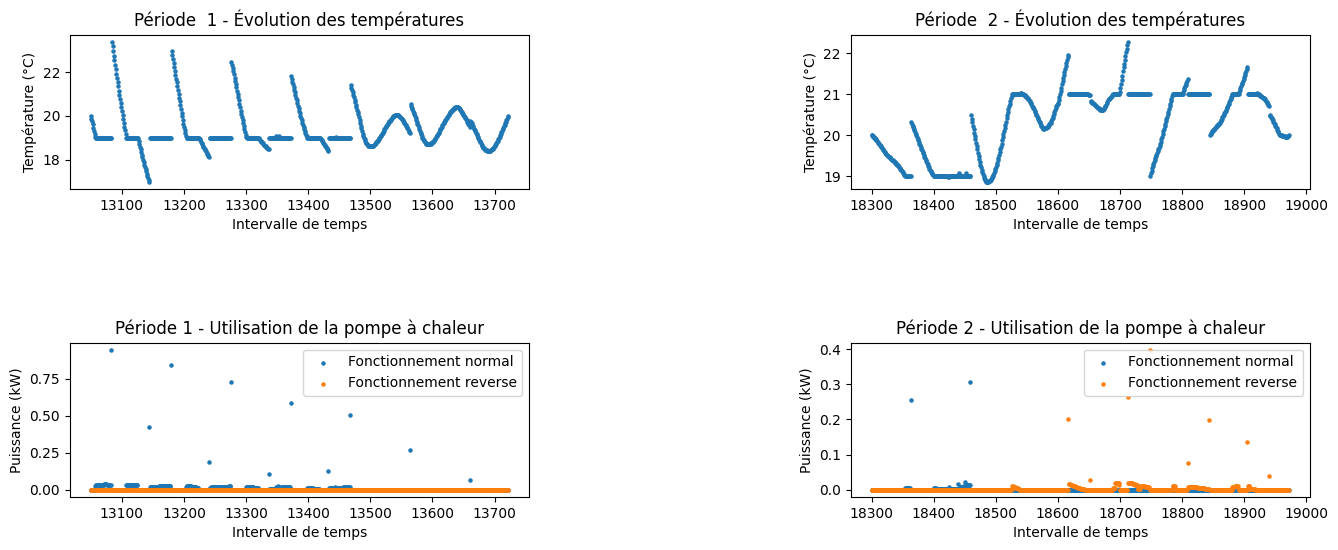

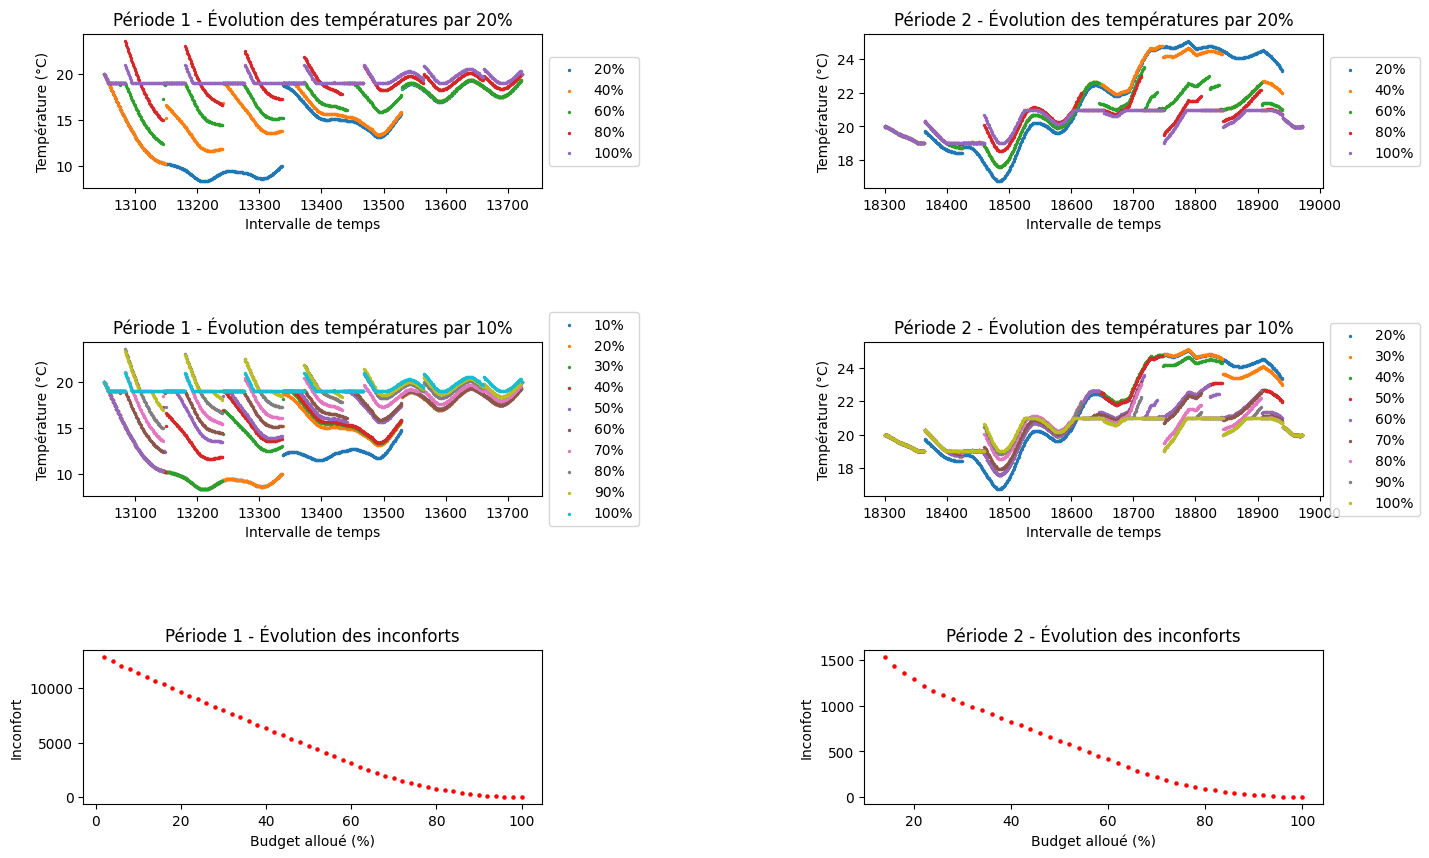

In [72]:
# Tache 1, période 1:
output_1_ref = basic(ref_week_start_idx)
print("Computed output_1_ref in {time}s".format(time=output_1_ref[-1]))

# Tache 1, période 2:
output_1_arbitrary = basic(arbitrary_week_start_idx)
print("Computed output_1_arbitrary in {time}s".format(time=output_1_arbitrary[-1]))

# Tache 2, période 1:
output_2_ref = basic(ref_week_start_idx, output_1_ref[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_ref[-1]))

# Tache 2, période 2:
output_2_arbitrary = basic(arbitrary_week_start_idx, output_1_arbitrary[3]*task_2_budget_coefficient)
print("Computed output_2_arbitrary in {time}s".format(time=output_2_arbitrary[-1]))

# Tache 3, période 1:
start = time.time()
output_3_ref = task3(ref_week_start_idx, output_1_ref[3])
print("Computed output_3_ref in {time}s".format(time=time.time()-start))
print("Average time for output_3_ref: {time}s".format(time=(time.time()-start)/51))

# Tache 3, période 2:
start = time.time()
output_3_arbitrary = task3(arbitrary_week_start_idx, output_1_arbitrary[3])
print("Computed output_3_arbitrary in {time}s".format(time=time.time()-start))
print("Average time for output_3_arbitrary: {time}s".format(time=(time.time()-start)/51))

# Plot les résultats
plot_1(output_1_ref, output_1_arbitrary, ref_week_start_idx, arbitrary_week_start_idx) 
plot_2(output_2_ref, output_2_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)
plot_3(output_3_ref, output_3_arbitrary, ref_week_start_idx, arbitrary_week_start_idx)